## 1. 导入模块

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

from tensorflow import keras
import tensorflow as tf
import sys
import os
import time
import datetime

for module in [np, pd, mpl, sklearn, keras, tf]:
    print(module.__name__, module.__version__)
    
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)

numpy 1.18.1
pandas 0.25.3
matplotlib 3.1.2
sklearn 0.22.1
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf
tensorflow 2.1.0


## 2. 加载数据

In [4]:
imdb = keras.datasets.imdb
vocab_size = 10000
index_from = 3

# 加载数据，词的数量为 vocab_size， 从index_from=3 后开始安排index
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size, index_from=index_from)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# word to index
word2index = imdb.get_word_index()
# 因为数据是从 index_from=3 开始安排的，所以，word2index 往后移3位
word2index = {word:(idx+3) for word, idx in word2index.items()} 

word2index["<PAD>"] = 0
word2index["<START>"] = 1
word2index["<UNK>"] = 2
word2index["<END>"] = 3

reversed_word2index = {v:k for k, v in word2index.items()}

(25000,) (25000,)
(25000,) (25000,)


In [5]:
# 解析数据
def decode_review(text_ids):
    return " ".join([reversed_word2index[ids] for ids in text_ids])

print(decode_review(x_train[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [7]:
# 补全数据
max_length = 500

x_train = keras.preprocessing.sequence.pad_sequences(
    x_train, # list of list
    value=word2index["<PAD>"], # 填充数
    padding="post",  # 往后填充
    maxlen=max_length) # 最大长度

x_test = keras.preprocessing.sequence.pad_sequences(
    x_test, # list of list
    value=word2index["<PAD>"],
    padding="post",
    maxlen=max_length)

# print(x_train[0])

## 3. 建模训练

In [9]:
embedding_dim = 16
batch_size = 128

def build_model(vocab_size, embedding_dim, max_length):
    model = keras.models.Sequential([
        # 输入数据：batch_size * max_length
        
        # 词表矩阵          vocab_size * embedding_dim
        # 每个词输入的矩阵：max_length * embedding_dim
        # 每批词的输出矩阵：batch_size * max_length * embedding_dim
        keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length), # batch_size * max_length * embedding_dim
        
        # 全局平均池化
        keras.layers.GlobalAveragePooling1D(), # batch_size * embedding_dim
        keras.layers.Dense(64, activation="relu"),  # batch_size * 64
        keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

model = build_model(vocab_size, embedding_dim, max_length)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=batch_size)

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 2s 78us/sample - loss: 0.6851 - accuracy: 0.6105 - val_loss: 0.6528 - val_accuracy: 0.7668
Epoch 2/100
20000/20000 [==============================] - 1s 44us/sample - loss: 0.5513 - accuracy: 0.7987 - val_loss: 0.4444 - val_accuracy: 0.8360
Epoch 3/100
20000/20000 [==============================] - 1s 48us/sample - loss: 0.3639 - accuracy: 0.8716 - val_loss: 0.3420 - val_accuracy: 0.8692
Epoch 4/100
20000/20000 [==============================] - 1s 47us/sample - loss: 0.2831 - accuracy: 0.8963 - val_loss: 0.3076 - val_accuracy: 0.8798
Epoch 5/100
20000/20000 [==============================] - 1s 46us/sample - loss: 0.2421 - accuracy: 0.9125 - val_loss: 0.2953 - val_accuracy: 0.8858
Epoch 6/100
20000/20000 [==============================] - 1s 46us/sample - loss: 0.2149 - accuracy: 0.9194 - val_loss: 0.2852 - val_accuracy: 0.8866
Epoch 7/100
20000/20000 [==========================

Epoch 55/100
20000/20000 [==============================] - 1s 46us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.1117 - val_accuracy: 0.8686
Epoch 56/100
20000/20000 [==============================] - 1s 46us/sample - loss: 8.5188e-04 - accuracy: 1.0000 - val_loss: 1.1292 - val_accuracy: 0.8688
Epoch 57/100
20000/20000 [==============================] - 1s 46us/sample - loss: 8.9988e-04 - accuracy: 1.0000 - val_loss: 1.1463 - val_accuracy: 0.8684
Epoch 58/100
20000/20000 [==============================] - 1s 48us/sample - loss: 8.2677e-04 - accuracy: 1.0000 - val_loss: 1.1655 - val_accuracy: 0.8656
Epoch 59/100
20000/20000 [==============================] - 1s 46us/sample - loss: 7.0890e-04 - accuracy: 1.0000 - val_loss: 1.1835 - val_accuracy: 0.8670
Epoch 60/100
20000/20000 [==============================] - 1s 48us/sample - loss: 5.9413e-04 - accuracy: 1.0000 - val_loss: 1.2008 - val_accuracy: 0.8686
Epoch 61/100
20000/20000 [==============================] - 1s 47us/sample

In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

(0, 1.8)

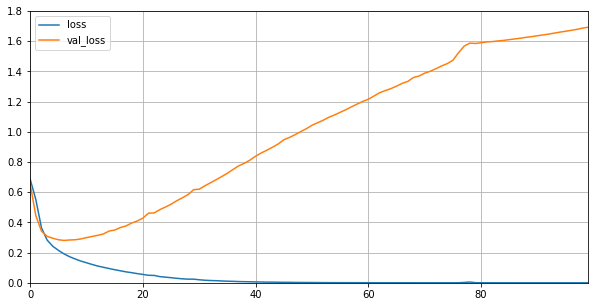

In [15]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot(figsize=(10, 5))
plt.grid(True)
plt.ylim(0, 1.8)

(0, 1)

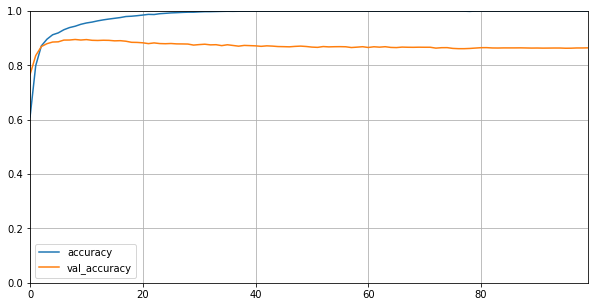

In [16]:
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot(figsize=(10, 5))
plt.grid(True)
plt.ylim(0, 1)

In [17]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 55us/sample - loss: 1.8437 - accuracy: 0.8446


[1.8437353500636295, 0.8446]